In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib

import harmonica as hm
import verde as vd
from skimage import data, img_as_float

import skimage.exposure

from skimage.filters import rank

import micromag as mg
import magali as ma
import time

## Generate dipole moments distribution

In [23]:
vector_size = 2500
dispersion = np.deg2rad(50)  

alpha = np.deg2rad(np.random.uniform(0,360,vector_size))
r = np.random.normal(0, dispersion, vector_size)

x = np.sin(r)*np.cos(alpha)
y = np.sin(r)*np.sin(alpha)
z = np.cos(r)



r_vector = np.array([x,y,z])
# r_vector

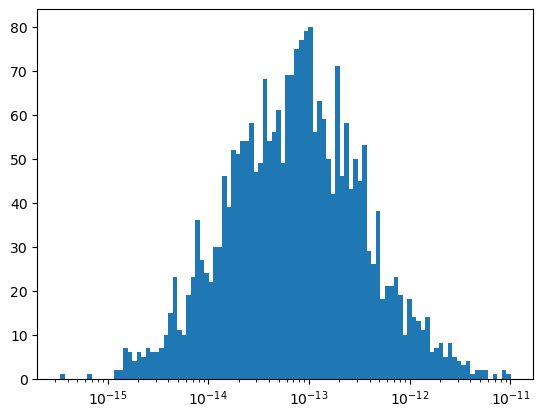

In [24]:
amp = ma.amplitude_lognormal_distribution(vector_size, 2.0)

count, bins = np.histogram(amp, bins=100, density=True)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.subplot(111)
plt.hist(amp, bins=logbins)
plt.xscale('log')
plt.show()

In [15]:
inc = 30
dec = 30
rotatated_vector = ma.rotate_vector(r_vector*amp, inc, dec)

In [16]:
test = np.sum(rotatated_vector.T, axis=0)
test_ang = mg.vector_to_angles(test)
test_ang

(30.201954349591674, 27.73056101217316, 7.468255129448118e-10)

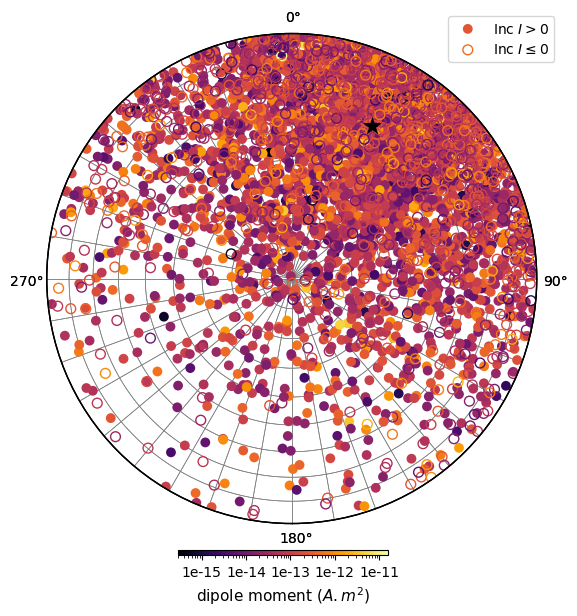

In [17]:
projection = mg.StereographicProjection(rotatated_vector.T)
projection_R = mg.StereographicProjection(np.reshape(test,(1,3)))


# estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
# vmin = np.min(estimated)
# vmax = np.max(estimated)
cmap = "inferno"
# Use matplotlib.colors.LogNorm for a log scale
cmap_norm = matplotlib.colors.LogNorm #Normalize

kwargs = dict(
    s=50, cmap=cmap, cmap_norm=cmap_norm
)   

# Plota a projeção estereográfica
fig, ax = plt.subplots(figsize=(7,7))
tmp = projection.plot(ax=ax, draw_cross=False, add_radial_grid=True, label="Inc", add_legend=True, **kwargs)
tmp_R = projection_R.plot(ax=ax, marker='*', s=200)
clb = fig.colorbar(
        tmp, 
        # cax=fig.add_axes([0.12, -0.025, 0.73, 0.0075]), 
        cax=fig.add_axes([0.35, 0.1, 0.3, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
clb.set_label(label="dipole moment ($A.m^2$)", fontsize=11)
clb.ax.tick_params(labelsize=10)
plt.show()

In [18]:
dipole_moments = np.copy(rotatated_vector.T)

In [19]:
dipole_coordinates = (
    np.random.randint(0, 2000, vector_size),  # µm
    np.random.randint(0, 1400, vector_size),  # µm
    np.random.randint(-20, -1, vector_size),  # µm
)

## Generate grid coordinates

In [20]:
sensor_sample_distance = 5.0  # µm
coordinates = vd.grid_coordinates(
    region=[0, 2000, 0, 1400],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)

In [21]:
# bz_regional = mg.dipole_bz(coordinates, deep_dipole_coordinates, deep_dipole_moments)
bz = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
# data = vd.make_xarray_grid(coordinates, bz+bz_regional, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data = vd.make_xarray_grid(coordinates, bz, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data.x.attrs = {"units": "µm"}
data.y.attrs = {"units": "µm"}
data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}


# Add some random noise to make it more realistic.
noise_std_dev = 50  # nT
data.bz.values += mg.gaussian_noise(noise_std_dev, data.bz.shape, seed=42)
# Add a positive shift to the data 
data.bz.values += 2000 # nT

data

<xarray.Dataset> Size: 11MB
Dimensions:  (y: 701, x: 1001)
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 6kB 0.0 2.0 4.0 6.0 ... 1.396e+03 1.398e+03 1.4e+03
    z        (y, x) float64 6MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 6MB 1.507e+03 1.291e+03 ... 5.444e+03 4.999e+03

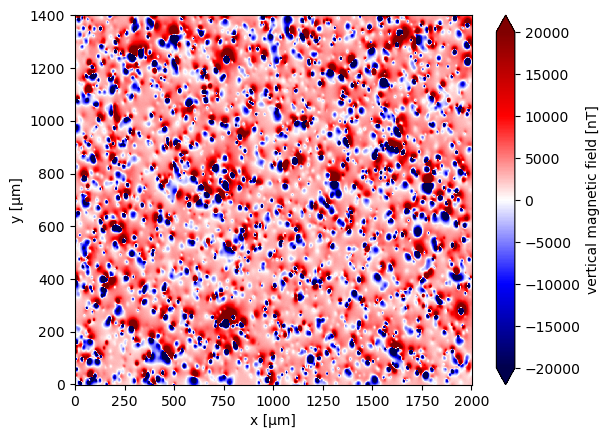

In [22]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=20000, vmin=-20000)

In [12]:
print(mg.vector_to_angles(np.sum(dipole_moments, axis=0)))

(31.873367580282498, 30.651132724616257, 4.323428687878795e-10)
